**we have used two different dataset of brain MRI**

(1) Figshare dataset

(2) Kaggle open source (4-class dataset containig 3264 brain MRI images)

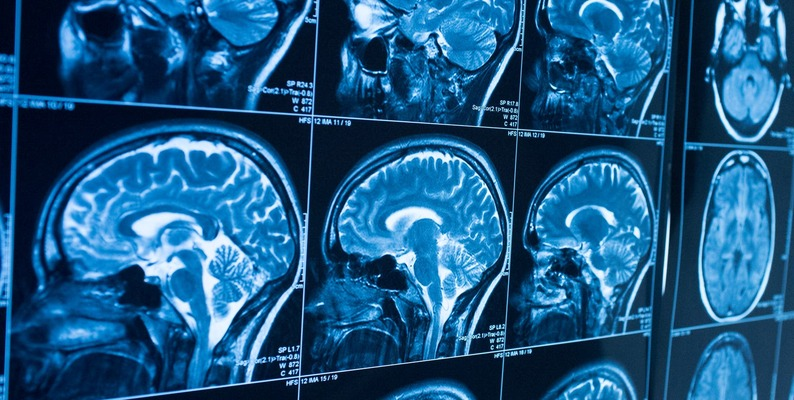

**Connect to Google Drive to access Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**First we have crop the dataset because the image contain too much empty spaces. so thats why we have performed two type of experiments using our proposed model**

In [ ]:
# Install all dependencies
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
init_notebook_mode(connected=True)
RANDOM_SEED = 123

**Create New folder to save the cropped dataset**

In [ ]:
!apt-get install tree 
# create new folders
!mkdir TRAIN TEST VAL TRAIN/MENINGIOMA TRAIN/GLIOMA TRAIN/PITUITARY TEST/MENINGIOMA TEST/GLIOMA TEST/PITUITARY VAL/MENINGIOMA VAL/GLIOMA VAL/PITUITARY
!tree -d

In [ ]:
IMG_PATH = '/content/drive/'           # Dataset Directory
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)    # Size can be changed according to the model input requirement

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

**Function to count the classes training, validation and test set**

In [ ]:

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

**Function to show/plot random samples from training set**

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

plot_samples(X_train, y_train, labels, 30)


**In order to crop only the part of the brain that contains the image, we use cropping techniques to find the extreme top, bottom, left, and right points of the brain.**

In [ ]:

def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
img = cv2.imread('/content/TRAIN/GLIOMA/0.png')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

**we have applied the following 4 steps to crop the brain part from the MRI images (To better understand what it is doing, let's grab an image from the dataset and apply this crop function to see the result:)**

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
# Apply the cropping strategy to each of the set that contain training, validation and testing.
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)
# randomly plot the images from the cropped dataset.
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
# we have save the three class cropped images in PNG format
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'GLIOMA/'+str(i)+'.png', img)
        elif imclass == 1:
            cv2.imwrite(folder_name+'MENINGIOMA/'+str(i)+'.png', img)
        else:
            cv2.imwrite(folder_name+'PITUITARY/'+str(i)+'.png', img)

        i += 1

In [ ]:
# path to saving new cropped images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/MENINGIOMA TRAIN_CROP/GLIOMA TRAIN_CROP/PITUITARY TEST_CROP/MENINGIOMA TEST_CROP/GLIOMA TEST_CROP/PITUITARY VAL_CROP/MENINGIOMA VAL_CROP/GLIOMA VAL_CROP/PITUITARY
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

**Function to count the classes training, validation and test set**

In [ ]:

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

**Function to show/plot random samples from training set**

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

plot_samples(X_train, y_train, labels, 30)


**The same procedure is applied on the 4 class dataset to crop the images from all classes and save it in the new folders to train the model.**

**We have performed 2 different experiments on each model**

(1) Orignal Dataset (3 class)

(2) Cropped Dataset (3 class)


# **First experiment on orignal 3 class dataset**

**If you want to access dataset from kaggle then you can run the following three tabs to download the dataset**

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file

In [ ]:
!kaggle datasets download  # api copied from kaggle (to download dataset from kaggle)

In [ ]:
!unzip /content/brain-tumor.zip # (to unzip the dataset)

**Installing and Importing Libraries**

In [ ]:
import os
import math
import random
import itertools
import numpy as np
import tensorflow as tf
SEED = 7
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.backend as K

import re
import imageio
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report

In [ ]:
try:
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print("Tensorflow version ", tf.__version__)

Number of replicas: 1
Tensorflow version  2.8.0


**We have performed experiments on 5 Deep Learning Models using Transfer Learning technique**

**We have the trained these models one by one on both orignal and cropped dataset**

**Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory, Today, most models use the float32 dtype, which takes 32 bits of memory.**

In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('float32')
mixed_precision.set_policy(policy)

**Cosine Annealing is a type of learning rate schedule that has the effect of starting with a large learning rate that is relatively rapidly decreased to a minimum value before being increased rapidly again.**

In [ ]:
# Cosine annealing scheduler, is a type of learning rate schedule that has the effect of starting with a large learning rate that is relatively rapidly decreased
from tensorflow.keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler'
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

**Getting paths and directories, setting global variables**

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True)

dataset_id = '/content/drive/' # path of the saved dataset.

BATCH_SIZE = 64 * strategy.num_replicas_in_sync # 64 batch size is used to train all the considered models (# try reducing batch size if your GPU runs out of memory)

CLASSES = ['GLIOMA', 'MENINGIOMA', 'PITUITARY'] # brain MRI dataset have 3 classes
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = [224, 224] # each model have different input size
input_shape = (224, 224, 3) # (meaning width, height and # of channels)
LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2) # categorical cross entropy loss function is used to train these models

METRICS = ['accuracy']

**Getting paths and directories**

In [ ]:
filenames = tf.io.gfile.glob(str('/content/drive/GLIOMA/*'))
filenames.extend(tf.io.gfile.glob(str('/content/drive/MENINGIOMA/*')))
filenames.extend(tf.io.gfile.glob(str('/content/drive/PITUITARY/*')))

# Randomly shuffles the elements of this dataset.
# it helps the training converge fast. it prevents any bias during the training
random.shuffle(filenames)

**print the total number of Brain MRI images from each classes**

In [ ]:
COUNT_glioma = len([filename for filename in filenames if "/GLIOMA/" in filename])
print("GLIOMA images count : " + str(COUNT_glioma))

COUNT_meningioma = len([filename for filename in filenames if "/MENINGIOMA/" in filename])
print("MENINGIOMA images count : " + str(COUNT_meningioma))

COUNT_pituitary = len([filename for filename in filenames if "/PITUITARY/" in filename])
print("PITUITARY images count : " + str(COUNT_pituitary))

**Train Test Split**

In [ ]:
# 20% of the dataset is used for testing purpose
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2)
train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2)

**Train, validation and test split**

In [ ]:
# 80% of the dataset is used for training purpose
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
# 20% of the dataset is used for testing the proposed model
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

**It will show the total number of MRI images that are used in training, validation and testing**

In [ ]:
# print the total images for training 
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Total Training Images: " + str(TRAIN_IMG_COUNT))

# print the total images for validation
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Total Validation images: " + str(VAL_IMG_COUNT))

# print the total images for testing
Test_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print("Total Testing images: " + str(Test_IMG_COUNT))

In [ ]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return int(parts[-2] == CLASSES)

In [ ]:
#Detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
def prepare_for_training(ds, cache=True):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)

    if cache:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = prepare_for_training(test_ds, False)

**Pre-processing and Data Augmentation**

In [ ]:
# Data augmentation is a technique to artificially create new training data from existing training data
# Improving model prediction accuracy. adding more training data into the models. preventing data scarcity for better models

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomContrast(factor=0.20),      # contraast
  layers.experimental.preprocessing.RandomRotation(90),
] ,name="Data_Augmentation")

In [ ]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break
    return numpy_images, numpy_labels

x_test, y_test = dataset_to_numpy_util(test_ds, Test_IMG_COUNT)

print("Evaluation Dataset:")
print('X shape: ', x_test.shape,' Y shape: ', y_test.shape)

In [ ]:
def weight_classes(extra_weight=False, ew_value=1):
    total_COUNT = COUNT_glioma + COUNT_meningioma + COUNT_pituitary

    weight_for_0 = (1 / COUNT_glioma) * total_COUNT / 2.0  # weight for glioma class
    weight_for_1 = (1 / COUNT_meningioma) * total_COUNT / 2.0 # weight for meningioma class
    weight_for_2 = (1 / COUNT_pituitary) * total_COUNT / 2.0  # weight for pituitary class
    if extra_weight:
        weight_for_1 *= ew_value

    class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2} 

    print(f'Weight for class 0: {weight_for_0}')
    print(f'Weight for class 1: {weight_for_1}')
    print(f'Weight for class 2: {weight_for_2}')
    return class_weight
class_weight = weight_classes(extra_weight=False, ew_value=1.5)


**We have used our deep dense block at the top of each model to improve the performance.**

**We add our deep dense block that contain batch normalization layers, dense layers and drop out layer to improve the classification of the proposed model**

**we have added Batch Normalization Layers in the deep dense block (Networks train faster · Allows higher learning rates · Makes weights easier to initialize)**

**We have performed experiments on 5 Deep Learning Models using Transfer Learning technique**

**We have the trained these models one by one on both orignal and cropped dataset**

In [ ]:
from tensorflow.keras.applications.xception import Xception
DL_Model = Xception

#from tensorflow.keras.applications.densenet import DenseNet201
#NETWORK = DenseNet201

#from tensorflow.keras.applications.densenet import DenseNet121
#NETWORK = DenseNet121

#from tensorflow.keras.applications.resnet_v2 import ResNet152V2
#NETWORK = ResNet152V2

#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
#NETWORK = InceptionResNetV2

In [ ]:
def build_model(OPTIMIZER, LOSS, METRICS):
    model = None
    inputs = layers.Input(shape=input_shape)
    first = data_augmentation(inputs)

    base_Model = DL_Model(include_top=False, input_tensor=first, weights="imagenet", pooling ='avg')

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional layers

    base_Model.trainable = False

    deep_dense_block = layers.BatchNormalization(axis = -1)(base_Model.output)
    
    # first fully connected layer contain 512 neurons with regularization to avoid overfitting in the model.   
    deep_dense_block = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(deep_dense_block)
   
   # deep_dense_block = layers.Dense(1024, activation='relu')(deep_dense_block)

    deep_dense_block = layers.BatchNormalization(axis = -1)(deep_dense_block)       # we uses axis=-1 as a default value and states that the feature axis is typically normalized.
    deep_dense_block = layers.Dropout(.2)(deep_dense_block)                         # dropout of 20% is used to avoid overfitting
    deep_dense_block = layers.Dense(256, activation='relu')(deep_dense_block)       # fully connected layer with 256 neurons and relu activation
  
   # deep_dense_block = layers.Dense(64, activation='relu')(deep_dense_block)
   
    deep_dense_block = layers.BatchNormalization(axis = -1)(deep_dense_block)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="Final_Classification_Layer")(deep_dense_block) # we have 3 class and 4 class in dataset
   
    model = tf.keras.Model(inputs=base_Model.input, outputs=outputs, name="Proposed_Model")
   
    model.compile(optimizer = OPTIMIZER,
                  loss = LOSS,
                  metrics = METRICS)
        
    return model

**Hyperparameters used to train the models**

In [ ]:
Epochs = 50 # 50 epochs used to train the models
Early_Stop = 10 # early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method
OPTIMIZER = tensorflow.keras.optimizers.Adam(lr = 1e-2, decay = 1e-5)


Callbacks = [
    CosineAnnealingScheduler(Epochs, 1e-3, 1e-6),
    # early stopping method is used, it is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.
    EarlyStopping(monitor='val_accuracy',
                  patience=Early_Stop,
                  mode='auto',
                  min_delta=0.00001,
                  verbose=2,
                  restore_best_weights=True)]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
with strategy.scope():
    model = build_model(OPTIMIZER, LOSS, METRICS)

In [ ]:
model.summary()

**Training the model**

**Callback** -> set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

**ModelCheckpoint** -> callback to save the Keras model or model weights at some frequency.

**EarlyStopping** -> stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau** -> reduce learning rate when a metric has stopped improving.

In [ ]:
def fit_model(Epochs, Callbacks, class_weight=None):
    history = model.fit(
        train_ds,         # train dataset
        validation_data=val_ds,   # validation dataset
        epochs=Epochs,         # 50 epoch is used to train the model
        callbacks=Callbacks,
        verbose=2,
        class_weight=class_weight
    )
    return history
    
history = fit_model(Epochs, Callbacks, class_weight=class_weight)

**Make Predictions and evaluate the model on test set**

In [ ]:
#Accuracy of the best model on the testing data
def evaluate_model(model):
    results = model.evaluate(test_ds, return_dict=True)
    print ('\nModel Evaluation:')
    print(results['accuracy']*100)
    return results
    
results = evaluate_model(model)

**Hyperparameters used to fine tune the models**

In [ ]:
Fine_Tuning_Epochs = 50 # 50 epochs used to train the models
Fine_Tuning_Early_Stop = 15 # early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method
Fine_Tuning_OPTIMIZER = tensorflow.keras.optimizers.Adam(lr = 1e-3, decay = 1e-6)
Fine_Tuning_filepath = "/content/model.h5" # path to save the best model

In [ ]:
fine_tuning_Callbacks = [
    # Reduce learning rate when a metric has stopped improving.
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.8,
                      patience=5,
                      verbose=2,
                      mode='min',
                      min_delta=0.00001,
                      cooldown=1,
                      min_lr=1e-6),

    # The ModelCheckpoint callback class allows you to define where to checkpoint the model weights
    
    ModelCheckpoint(Fine_Tuning_filepath,
                    monitor='val_accuracy',
                    verbose=2,
                    save_best_only=True,
                    save_weights_only=False,
                    mode='max'),
    
    EarlyStopping(monitor='val_loss',
                  patience=Fine_Tuning_Early_Stop,
                  mode='auto',
                  min_delta=0.000001,
                  verbose=2,
                  restore_best_weights=True)]

In [ ]:
def fine_tuning(OPTIMIZER, LOSS, METRICS):
    for layer in model.layers[-56:]: # [50, 56, 60]   # try to reduce batch size or freeze more layers if your GPU runs out of memory
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
           # base_model.trainable = True   # end to end training can also perform if there is high computing power
   
    model.compile(optimizer = Fine_Tuning_OPTIMIZER, loss = LOSS, metrics = METRICS)
    return model

with strategy.scope():
    model = fine_tuning(Fine_Tuning_OPTIMIZER, LOSS, METRICS)

In [ ]:
history = fit_model(Fine_Tuning_Epochs, fine_tuning_Callbacks, class_weight=class_weight)

In [ ]:
model = load_model(Fine_Tuning_filepath)

results = model.evaluate(test_ds, return_dict=True)
print ('\nModel Evaluation:')
print(results['accuracy']*100)

In [ ]:
# class-wise results of the proposed model
preds = model.predict(x_test)
categories = ['GLIOMA', 'MENINGIOMA', 'PITUITARY']
preds = np.round(preds,0)
class_metrics = metrics.classification_report(y_test, preds, target_names = categories, zero_division = 0)
print (class_metrics)

In [ ]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.gcf().set_dpi(300)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = categories,
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = categories,
                      title        = "Confusion Matrix, Normalized CM")

In [ ]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)


ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MSE = mean_squared_error(y_test, preds)

print('MSE:', MSE)
print('Accuracy:', ACC)
print('Precision:', PPV)
print('Recall:', TPR)
print('Specificity:', TNR)
print('Negative Predictive Value:', NPV)


**The same experiment is performed on 4 class dataset brain MRI dataset which contains (Normal, glioma, meningioma and pituitary class)**

**We just need to change the number of class in the above code and also needed some changes in the preprocessing, dataset path, training, to get the results from the proposed model**